In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import shap
import datetime as dt

=== Fraud Data Dataset ===
Shape: (151112, 11)
Columns: ['user_id', 'signup_time', 'purchase_time', 'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class']

Class distribution:
class
0    90.635423
1     9.364577
Name: proportion, dtype: float64
Fraud rate: 9.36%

Basic statistics for numerical features:
             user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.000000      76.000000  4.294850e+09   

               class  
count  151112.00

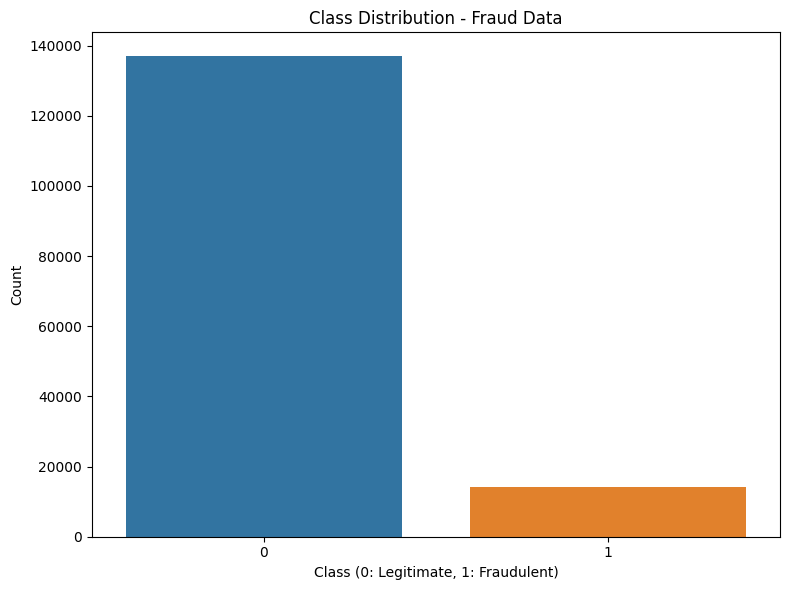

=== Credit Card Dataset ===
Shape: (284807, 31)
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64
Fraud rate: 0.17%

Basic statistics for numerical features:
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.5000

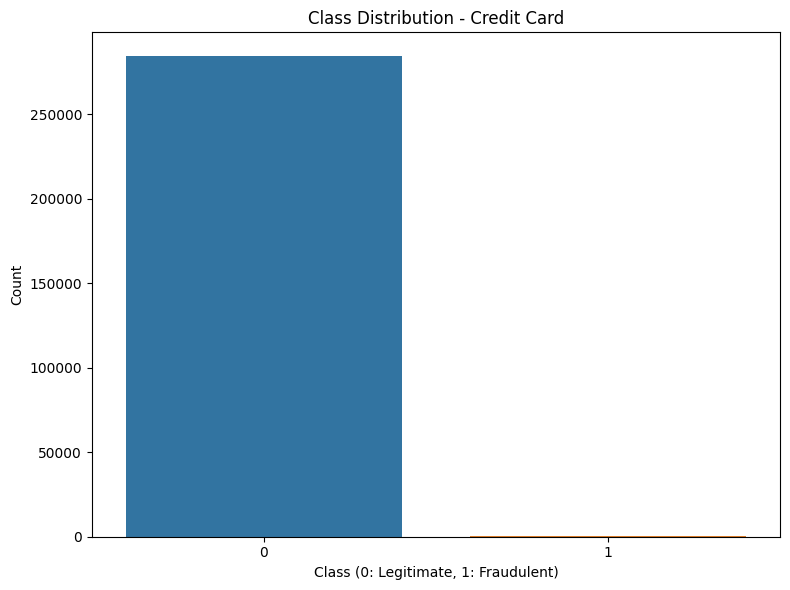

In [16]:
### initial data processing and exploration
# load both datasets
fraud_df = pd.read_csv('Fraud_Data.csv')
credit_card_df = pd.read_csv('creditcard.csv')

# function to handle different class column names/analyze class distribution
def explore_dataset(df, name):
    print(f"=== {name} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    class_col = 'Class' if 'Class' in df.columns else 'class'
    
    class_distribution = df[class_col].value_counts(normalize=True) * 100
    print("\nClass distribution:")
    print(class_distribution)
    print(f"Fraud rate: {class_distribution[1] if 1 in class_distribution else 0:.2f}%")
    
    print("\nBasic statistics for numerical features:")
    print(df.describe())
    
    plt.figure(figsize=(8, 6))
    sns.countplot(x=class_col, data=df)
    plt.title(f'Class Distribution - {name}')
    plt.xlabel('Class (0: Legitimate, 1: Fraudulent)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# explore both datasets
explore_dataset(fraud_df, "Fraud Data")
explore_dataset(credit_card_df, "Credit Card")

In [57]:
### preprocessing function for Fraud_Data dataset
# datetime formatting and create/extract time features
def preprocess_fraud_data(df):
    df['signup_time'] = pd.to_datetime(df['signup_time'])
    df['purchase_time'] = pd.to_datetime(df['purchase_time'])
    
    df['time_to_purchase'] = (df['purchase_time'] - df['signup_time']).dt.total_seconds() / 3600
    
    df['signup_hour'] = df['signup_time'].dt.hour
    df['purchase_hour'] = df['purchase_time'].dt.hour
    df['signup_day'] = df['signup_time'].dt.dayofweek
    df['purchase_day'] = df['purchase_time'].dt.dayofweek
    
    df.drop(['signup_time', 'purchase_time'], axis=1, inplace=True)
    
    categorical_features = ['source', 'browser', 'sex']
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    
    id_features = ['user_id', 'device_id']
    X = df_encoded.drop(['class'] + id_features, axis=1)
    y = df_encoded['class']
    
    return X, y

# standardize feature
scaler_fraud = StandardScaler()
X_train_fraud_scaled = scaler_fraud.fit_transform(X_train_fraud)
X_test_fraud_scaled = scaler_fraud.transform(X_test_fraud)

In [56]:
### preprocessing function for Credit Card dataset
def preprocess_credit_card(df):
    # normalize 'Amount' and 'Time' features
    scaler = StandardScaler()
    df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
    df['Time_scaled'] = scaler.fit_transform(df[['Time']])
    
    X = df.drop(['Class', 'Time', 'Amount'], axis=1)
    X['Amount_scaled'] = df['Amount_scaled']
    X['Time_scaled'] = df['Time_scaled']
    y = df['Class']
    
    return X, y

In [19]:
### preprocess both datasets
X_fraud, y_fraud = preprocess_fraud_data(fraud_df)
X_credit, y_credit = preprocess_credit_card(credit_card_df)

In [20]:
### train-test split for both datasets
X_train_fraud, X_test_fraud, y_train_fraud, y_test_fraud = train_test_split(X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud)
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.2, random_state=42, stratify=y_credit)

print(f"Fraud Data - Training set shape: {X_train_fraud_scaled.shape}, Test set shape: {X_test_fraud_scaled.shape}")
print(f"Fraud Data - Training fraud rate: {y_train_fraud.mean() * 100:.2f}%")

print(f"Credit Card - Training set shape: {X_train_credit.shape}, Test set shape: {X_test_credit.shape}")
print(f"Credit Card - Training fraud rate: {y_train_credit.mean() * 100:.2f}%")

Fraud Data - Training set shape: (120889, 15), Test set shape: (30223, 15)
Fraud Data - Training fraud rate: 9.36%
Credit Card - Training set shape: (227845, 30), Test set shape: (56962, 30)
Credit Card - Training fraud rate: 0.17%


In [21]:
### neural network
def create_model(input_dim, class_weight=None):
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(input_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.AUC(name='auc'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    
    return model

# class weights
fraud_weight = {0: 1, 1: (1/y_train_fraud.mean())}
credit_weight = {0: 1, 1: (1/y_train_credit.mean())}

print(f"Fraud Data class weight: {fraud_weight}")
print(f"Credit Card class weight: {credit_weight}")

Fraud Data class weight: {0: 1, 1: np.float64(10.678296970232312)}
Credit Card class weight: {0: 1, 1: np.float64(578.2868020304568)}


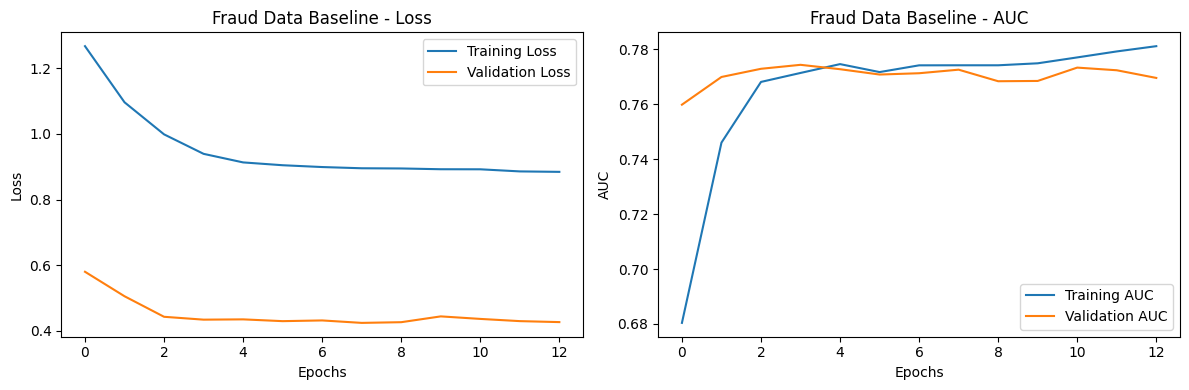

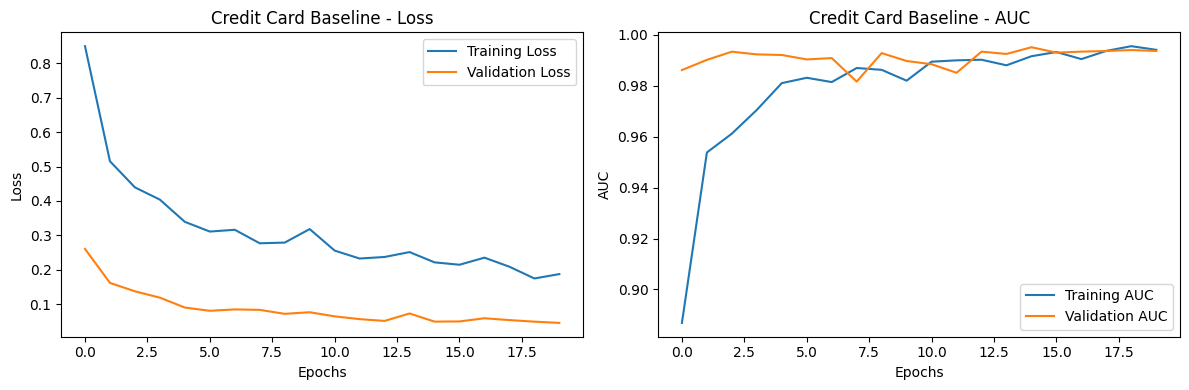

In [58]:
### baseline model - using the original data set, with class weights 
def create_model(input_dim, class_weight=None):
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        
        keras.layers.Dense(64, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                 keras.metrics.AUC(name='auc'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    
    return model
    
def plot_training_history(history, title):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.title(f'{title} - AUC')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_training_history(fraud_baseline_history, "Fraud Data Baseline")
plot_training_history(credit_baseline_history, "Credit Card Baseline")

In [25]:
### function to apply different sampling techniques
def apply_sampling(X_train, y_train, sampling_technique):
    if sampling_technique == 'over':
        sampler = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif sampling_technique == 'under':
        sampler = RandomUnderSampler(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    elif sampling_technique == 'smote':
        sampler = SMOTE(random_state=42)
        X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    else:
        X_resampled, y_resampled = X_train, y_train
    
    print(f"After {sampling_technique if sampling_technique else 'no'} sampling - Shape: {X_resampled.shape}, Fraud rate: {y_resampled.mean() * 100:.2f}%")
    return X_resampled, y_resampled

In [26]:
### apply sampling techniques to both datasets
# fraud data
X_train_fraud_over, y_train_fraud_over = apply_sampling(X_train_fraud_scaled, y_train_fraud, 'over')
X_train_fraud_under, y_train_fraud_under = apply_sampling(X_train_fraud_scaled, y_train_fraud, 'under')
X_train_fraud_smote, y_train_fraud_smote = apply_sampling(X_train_fraud_scaled, y_train_fraud, 'smote')

# credit card
X_train_credit_over, y_train_credit_over = apply_sampling(X_train_credit, y_train_credit, 'over')
X_train_credit_under, y_train_credit_under = apply_sampling(X_train_credit, y_train_credit, 'under')
X_train_credit_smote, y_train_credit_smote = apply_sampling(X_train_credit, y_train_credit, 'smote')

After over sampling - Shape: (219136, 15), Fraud rate: 50.00%
After under sampling - Shape: (22642, 15), Fraud rate: 50.00%
After smote sampling - Shape: (219136, 15), Fraud rate: 50.00%
After over sampling - Shape: (454902, 30), Fraud rate: 50.00%
After under sampling - Shape: (788, 30), Fraud rate: 50.00%
After smote sampling - Shape: (454902, 30), Fraud rate: 50.00%


In [27]:
### train models with resampled data - Fraud Data
fraud_over_model = create_model(X_train_fraud_scaled.shape[1])
fraud_over_history = fraud_over_model.fit(
    X_train_fraud_over, y_train_fraud_over,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

fraud_under_model = create_model(X_train_fraud_scaled.shape[1])
fraud_under_history = fraud_under_model.fit(
    X_train_fraud_under, y_train_fraud_under,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

fraud_smote_model = create_model(X_train_fraud_scaled.shape[1])
fraud_smote_history = fraud_smote_model.fit(
    X_train_fraud_smote, y_train_fraud_smote,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)



Epoch 1/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 2s 703us/step - accuracy: 0.6944 - auc: 0.6934 - loss: 0.6144 - precision: 0.6258 - recall: 0.5108 - val_accuracy: 0.5445 - val_auc: 0.0000e+00 - val_loss: 0.7643 - val_precision: 1.0000 - val_recall: 0.5445 - learning_rate: 0.0010
Epoch 2/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step - accuracy: 0.8197 - auc: 0.7712 - loss: 0.4479 - precision: 0.9544 - recall: 0.5467 - val_accuracy: 0.5421 - val_auc: 0.0000e+00 - val_loss: 0.6873 - val_precision: 1.0000 - val_recall: 0.5421 - learning_rate: 0.0010
Epoch 3/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - accuracy: 0.8256 - auc: 0.7708 - loss: 0.4314 - precision: 0.9850 - recall: 0.5421 - val_accuracy: 0.5416 - val_auc: 0.0000e+00 - val_loss: 0.6995 - val_precision: 1.0000 - val_recall: 0.5416 - learning_rate: 0.0010
Epoch 4/20
1370/1370 ━━━━━━━━━━━━━━━━━━━━ 1s 576us/step - accuracy: 0.8245 - auc: 0.7729 - loss: 0.4294 - precision: 0.9889 - recall: 0.5387 - val_accuracy: 0.5414 - val_auc: 0.0

In [28]:
# train models with resampled data for Credit Card
credit_over_model = create_model(X_train_credit.shape[1])
credit_over_history = credit_over_model.fit(
    X_train_credit_over, y_train_credit_over,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

credit_under_model = create_model(X_train_credit.shape[1])
credit_under_history = credit_under_model.fit(
    X_train_credit_under, y_train_credit_under,
    validation_split=0.2,
    epochs=20,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)

credit_smote_model = create_model(X_train_credit.shape[1])
credit_smote_history = credit_smote_model.fit(
    X_train_credit_smote, y_train_credit_smote,
    validation_split=0.2,
    epochs=20,
    batch_size=256,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
    ]
)


Epoch 1/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 2s 806us/step - accuracy: 0.9279 - auc: 0.9660 - loss: 0.1929 - precision: 0.9136 - recall: 0.8933 - val_accuracy: 0.9928 - val_auc: 0.0000e+00 - val_loss: 0.0287 - val_precision: 1.0000 - val_recall: 0.9928 - learning_rate: 0.0010
Epoch 2/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 709us/step - accuracy: 0.9843 - auc: 0.9984 - loss: 0.0445 - precision: 0.9792 - recall: 0.9790 - val_accuracy: 0.9950 - val_auc: 0.0000e+00 - val_loss: 0.0174 - val_precision: 1.0000 - val_recall: 0.9950 - learning_rate: 0.0010
Epoch 3/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9905 - auc: 0.9991 - loss: 0.0278 - precision: 0.9864 - recall: 0.9882 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0028 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/20
1422/1422 ━━━━━━━━━━━━━━━━━━━━ 1s 737us/step - accuracy: 0.9940 - auc: 0.9993 - loss: 0.0201 - precision: 0.9904 - recall: 0.9935 - val_accuracy: 1.0000 - val_auc: 0.0

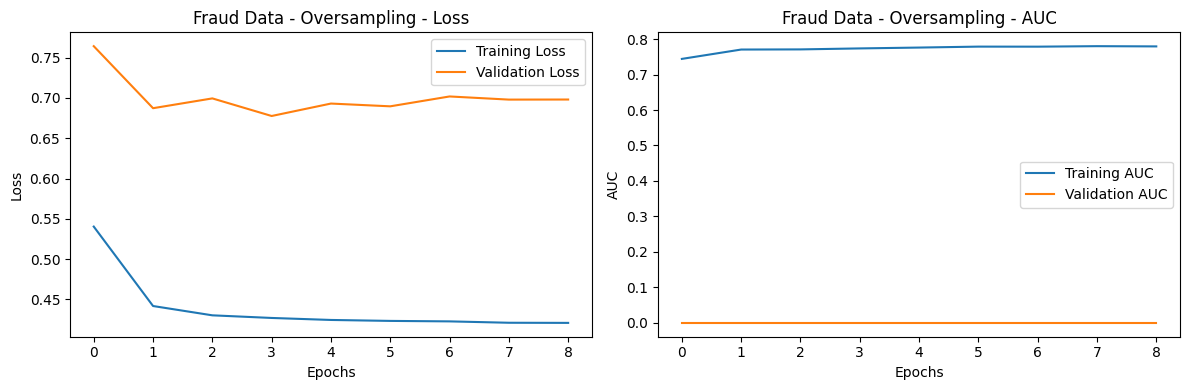

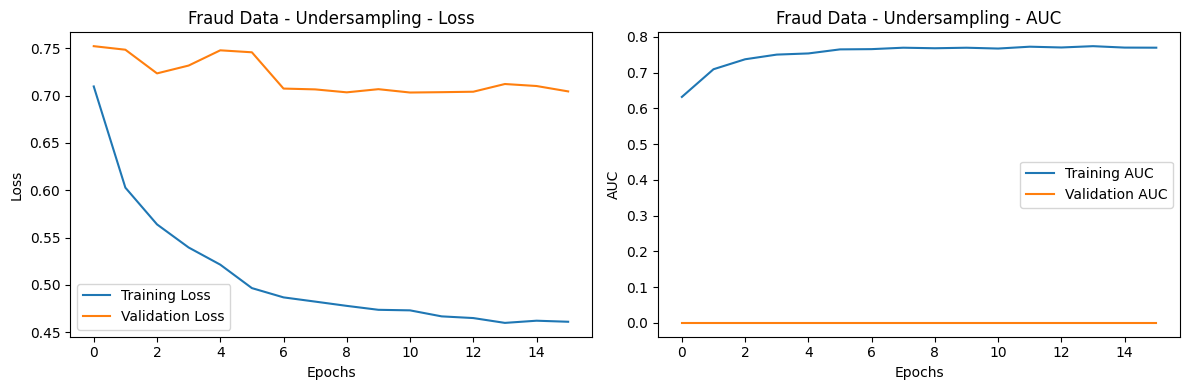

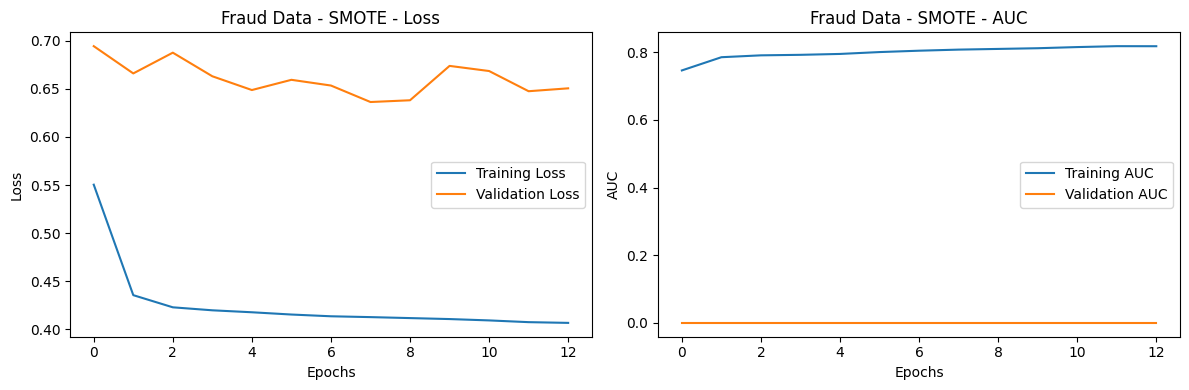

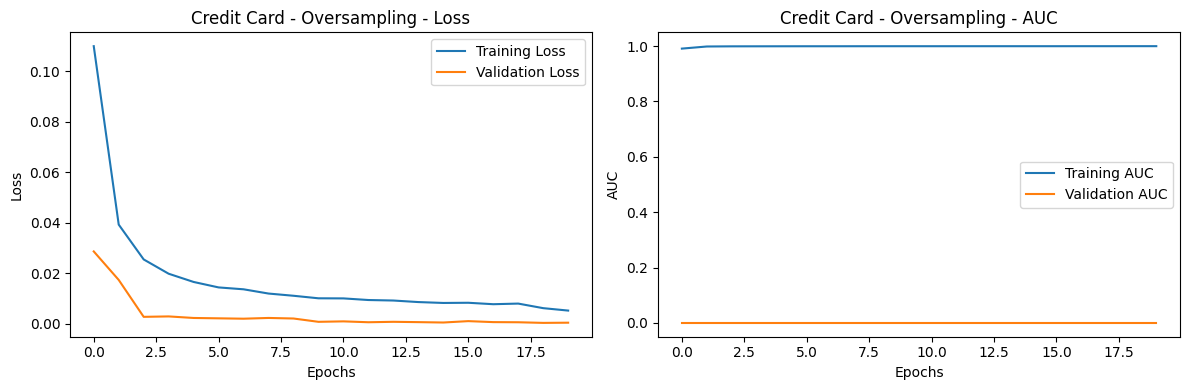

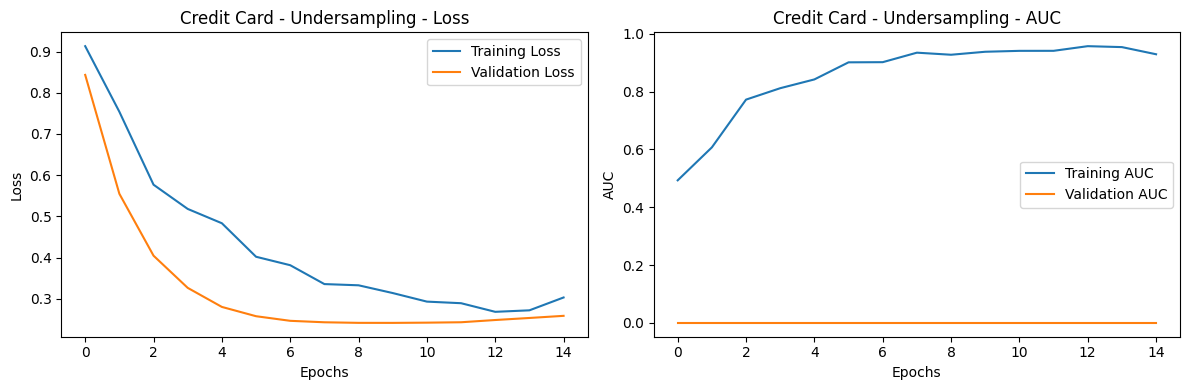

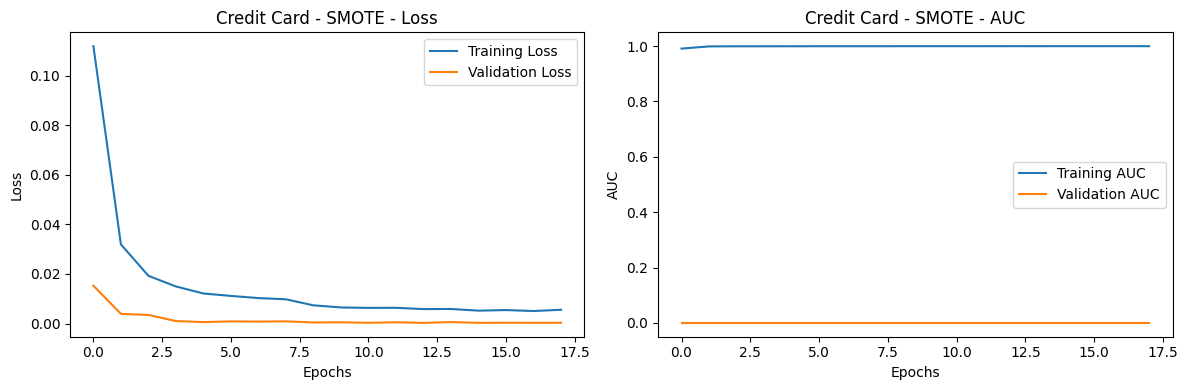

In [29]:
### plot training history for all models
plot_training_history(fraud_over_history, "Fraud Data - Oversampling")
plot_training_history(fraud_under_history, "Fraud Data - Undersampling")
plot_training_history(fraud_smote_history, "Fraud Data - SMOTE")

plot_training_history(credit_over_history, "Credit Card - Oversampling")
plot_training_history(credit_under_history, "Credit Card - Undersampling")
plot_training_history(credit_smote_history, "Credit Card - SMOTE")

In [30]:
### evaluate models
def evaluate_model(model, X_test, y_test, dataset_name, model_name):
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"=== {dataset_name} - {model_name} ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {dataset_name} - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, precision, recall, auc

945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 196us/step
=== Fraud Data - Baseline ===
Accuracy: 0.9542
Precision: 0.9683
Recall: 0.5286
AUC: 0.7687
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.97      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



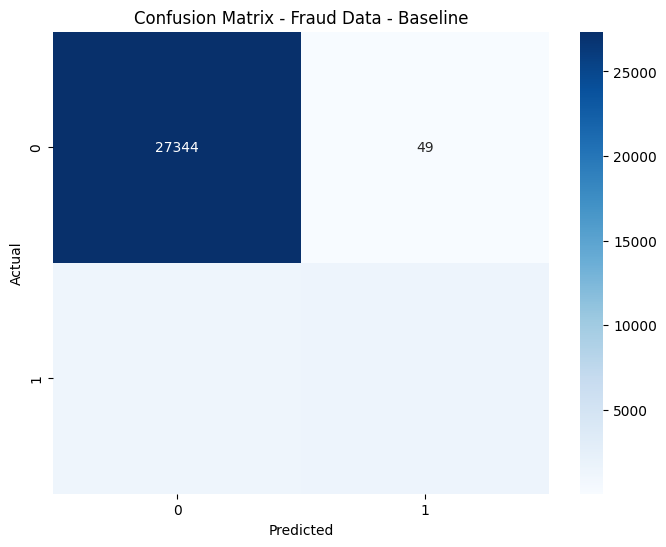

945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 189us/step
=== Fraud Data - Oversampling ===
Accuracy: 0.9548
Precision: 0.9797
Recall: 0.5283
AUC: 0.7672
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.98      0.53      0.69      2830

    accuracy                           0.95     30223
   macro avg       0.97      0.76      0.83     30223
weighted avg       0.96      0.95      0.95     30223



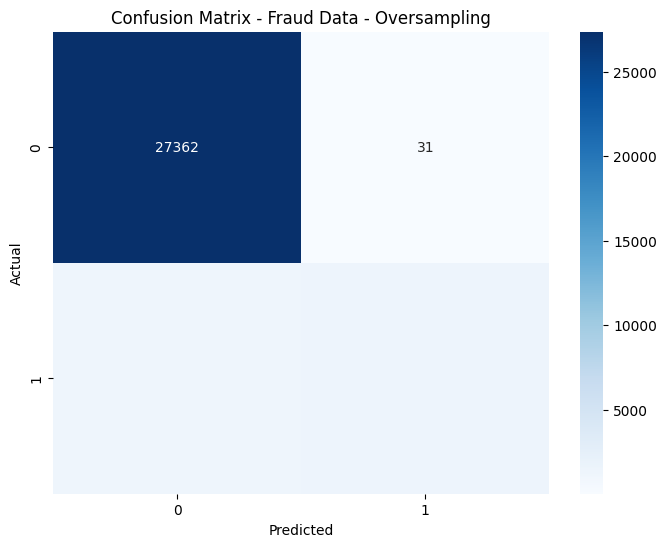

945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step
=== Fraud Data - Undersampling ===
Accuracy: 0.9373
Precision: 0.7214
Recall: 0.5389
AUC: 0.7689
              precision    recall  f1-score   support

           0       0.95      0.98      0.97     27393
           1       0.72      0.54      0.62      2830

    accuracy                           0.94     30223
   macro avg       0.84      0.76      0.79     30223
weighted avg       0.93      0.94      0.93     30223



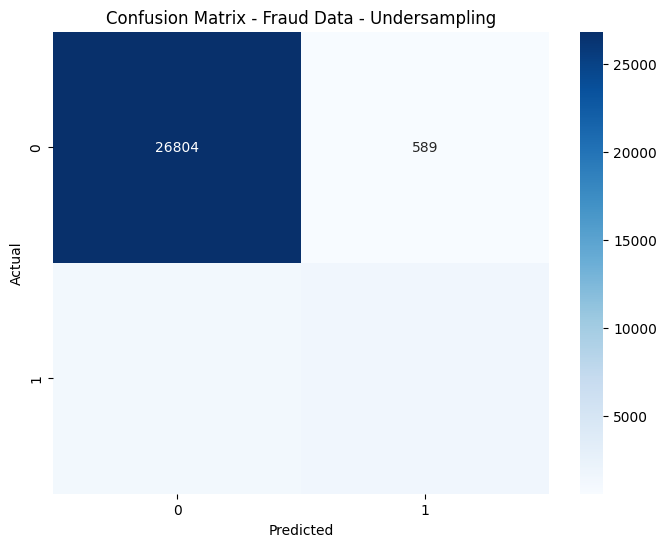

945/945 ━━━━━━━━━━━━━━━━━━━━ 0s 188us/step
=== Fraud Data - SMOTE ===
Accuracy: 0.9530
Precision: 0.9451
Recall: 0.5293
AUC: 0.7665
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     27393
           1       0.95      0.53      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.95      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223



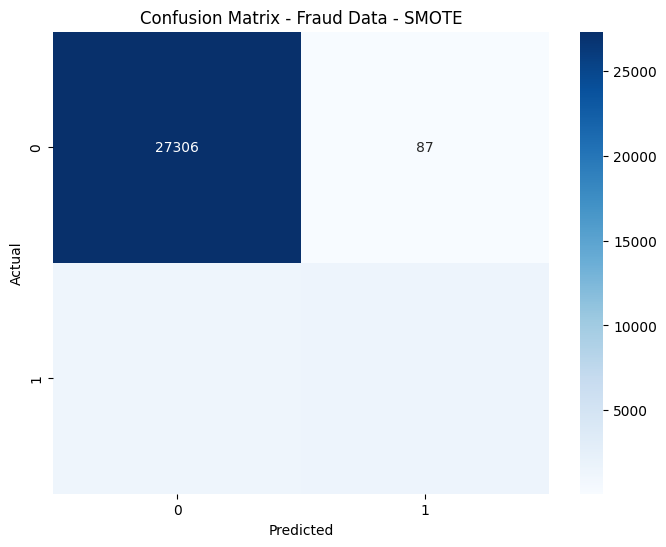

In [31]:
# evaluate all Fraud Data models
fraud_baseline_metrics = evaluate_model(fraud_baseline_model, X_test_fraud_scaled, y_test_fraud, "Fraud Data", "Baseline")
fraud_over_metrics = evaluate_model(fraud_over_model, X_test_fraud_scaled, y_test_fraud, "Fraud Data", "Oversampling")
fraud_under_metrics = evaluate_model(fraud_under_model, X_test_fraud_scaled, y_test_fraud, "Fraud Data", "Undersampling")
fraud_smote_metrics = evaluate_model(fraud_smote_model, X_test_fraud_scaled, y_test_fraud, "Fraud Data", "SMOTE")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 178us/step 
=== Credit Card - Baseline ===
Accuracy: 0.9868
Precision: 0.1080
Recall: 0.9184
AUC: 0.9812
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.11      0.92      0.19        98

    accuracy                           0.99     56962
   macro avg       0.55      0.95      0.59     56962
weighted avg       1.00      0.99      0.99     56962



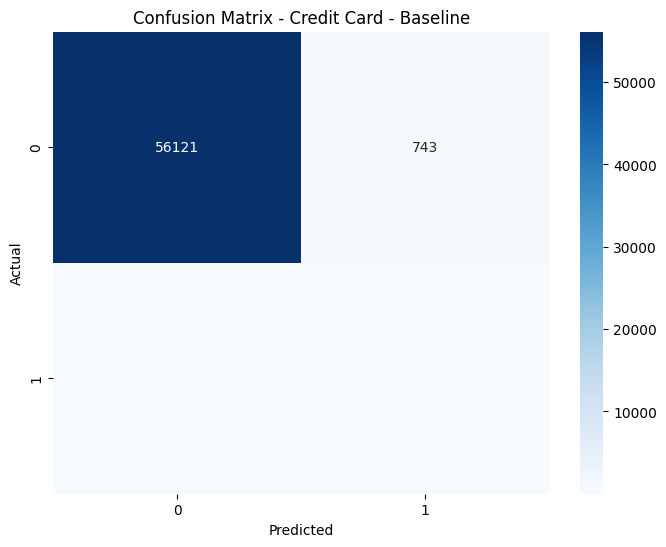

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 176us/step 
=== Credit Card - Oversampling ===
Accuracy: 0.9991
Precision: 0.6746
Recall: 0.8673
AUC: 0.9849
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.67      0.87      0.76        98

    accuracy                           1.00     56962
   macro avg       0.84      0.93      0.88     56962
weighted avg       1.00      1.00      1.00     56962



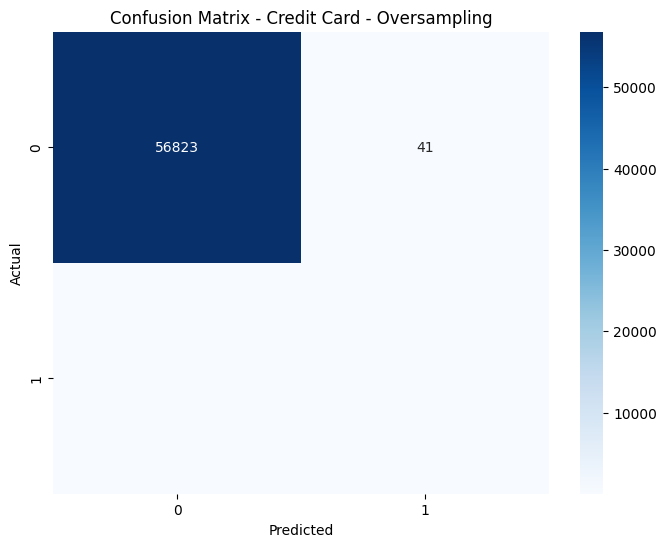

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 175us/step
=== Credit Card - Undersampling ===
Accuracy: 0.9765
Precision: 0.0597
Recall: 0.8571
AUC: 0.9664
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.86      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.92      0.55     56962
weighted avg       1.00      0.98      0.99     56962



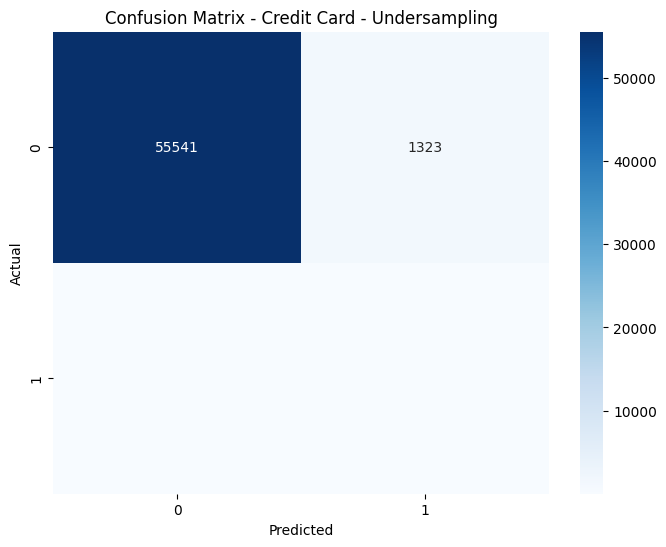

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 0s 177us/step
=== Credit Card - SMOTE ===
Accuracy: 0.9988
Precision: 0.6250
Recall: 0.8163
AUC: 0.9733
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.62      0.82      0.71        98

    accuracy                           1.00     56962
   macro avg       0.81      0.91      0.85     56962
weighted avg       1.00      1.00      1.00     56962



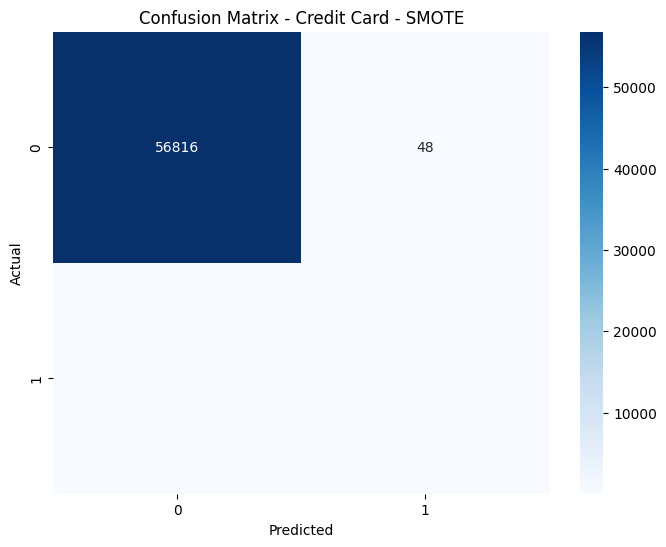

In [32]:
# evaluate all Credit Card models
credit_baseline_metrics = evaluate_model(credit_baseline_model, X_test_credit, y_test_credit, "Credit Card", "Baseline")
credit_over_metrics = evaluate_model(credit_over_model, X_test_credit, y_test_credit, "Credit Card", "Oversampling")
credit_under_metrics = evaluate_model(credit_under_model, X_test_credit, y_test_credit, "Credit Card", "Undersampling")
credit_smote_metrics = evaluate_model(credit_smote_model, X_test_credit, y_test_credit, "Credit Card", "SMOTE")

In [34]:
### comparison metrics 
def plot_comparison(metrics_list, labels, dataset_name):
    metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']
    metrics_data = np.array(metrics_list)
    
    x = np.arange(len(metrics))
    width = 0.2
    
    plt.figure(figsize=(14, 7))
    for i, (data, label) in enumerate(zip(metrics_data, labels)):
        plt.bar(x + (i - 1.5) * width, data, width, label=label)
    
    plt.ylabel('Score')
    plt.title(f'Performance Comparison - {dataset_name}')
    plt.xticks(x, metrics)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

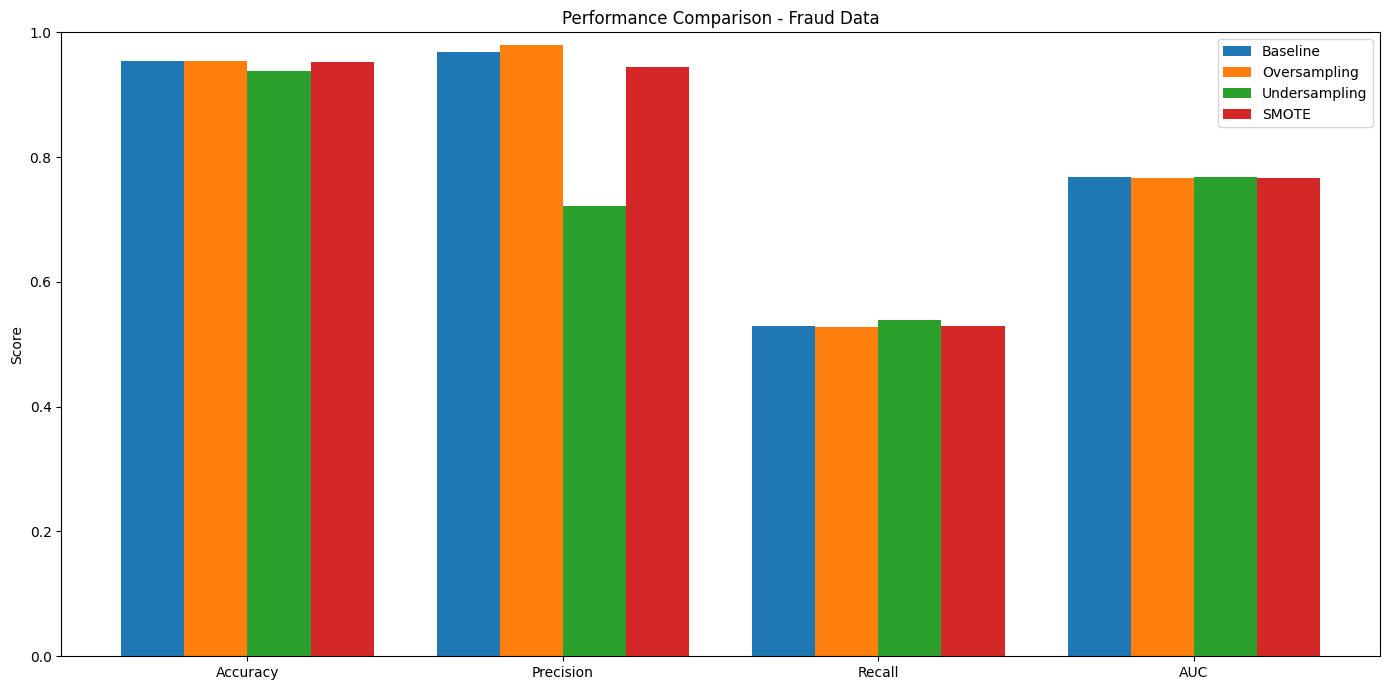

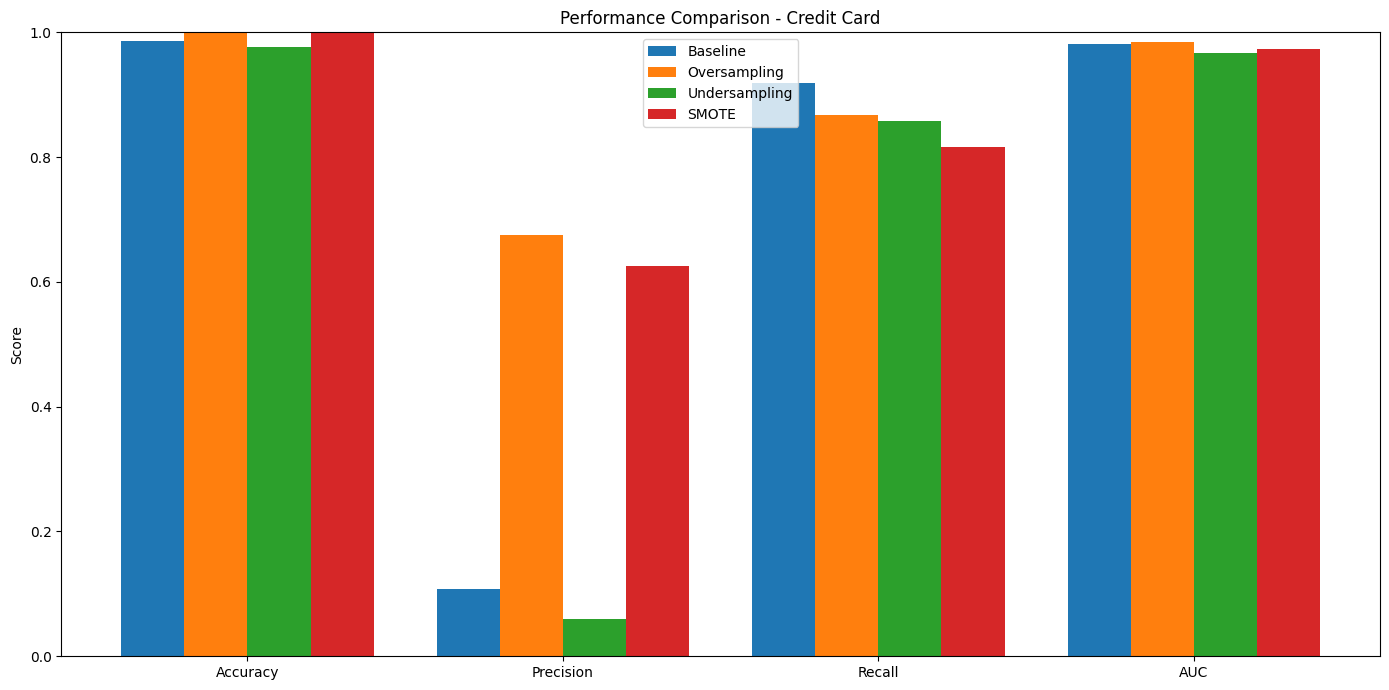

In [35]:
# compare models for each dataset
fraud_metrics = [fraud_baseline_metrics, fraud_over_metrics, fraud_under_metrics, fraud_smote_metrics]
fraud_labels = ['Baseline', 'Oversampling', 'Undersampling', 'SMOTE']
plot_comparison(fraud_metrics, fraud_labels, "Fraud Data")

credit_metrics = [credit_baseline_metrics, credit_over_metrics, credit_under_metrics, credit_smote_metrics]
credit_labels = ['Baseline', 'Oversampling', 'Undersampling', 'SMOTE']
plot_comparison(credit_metrics, credit_labels, "Credit Card")

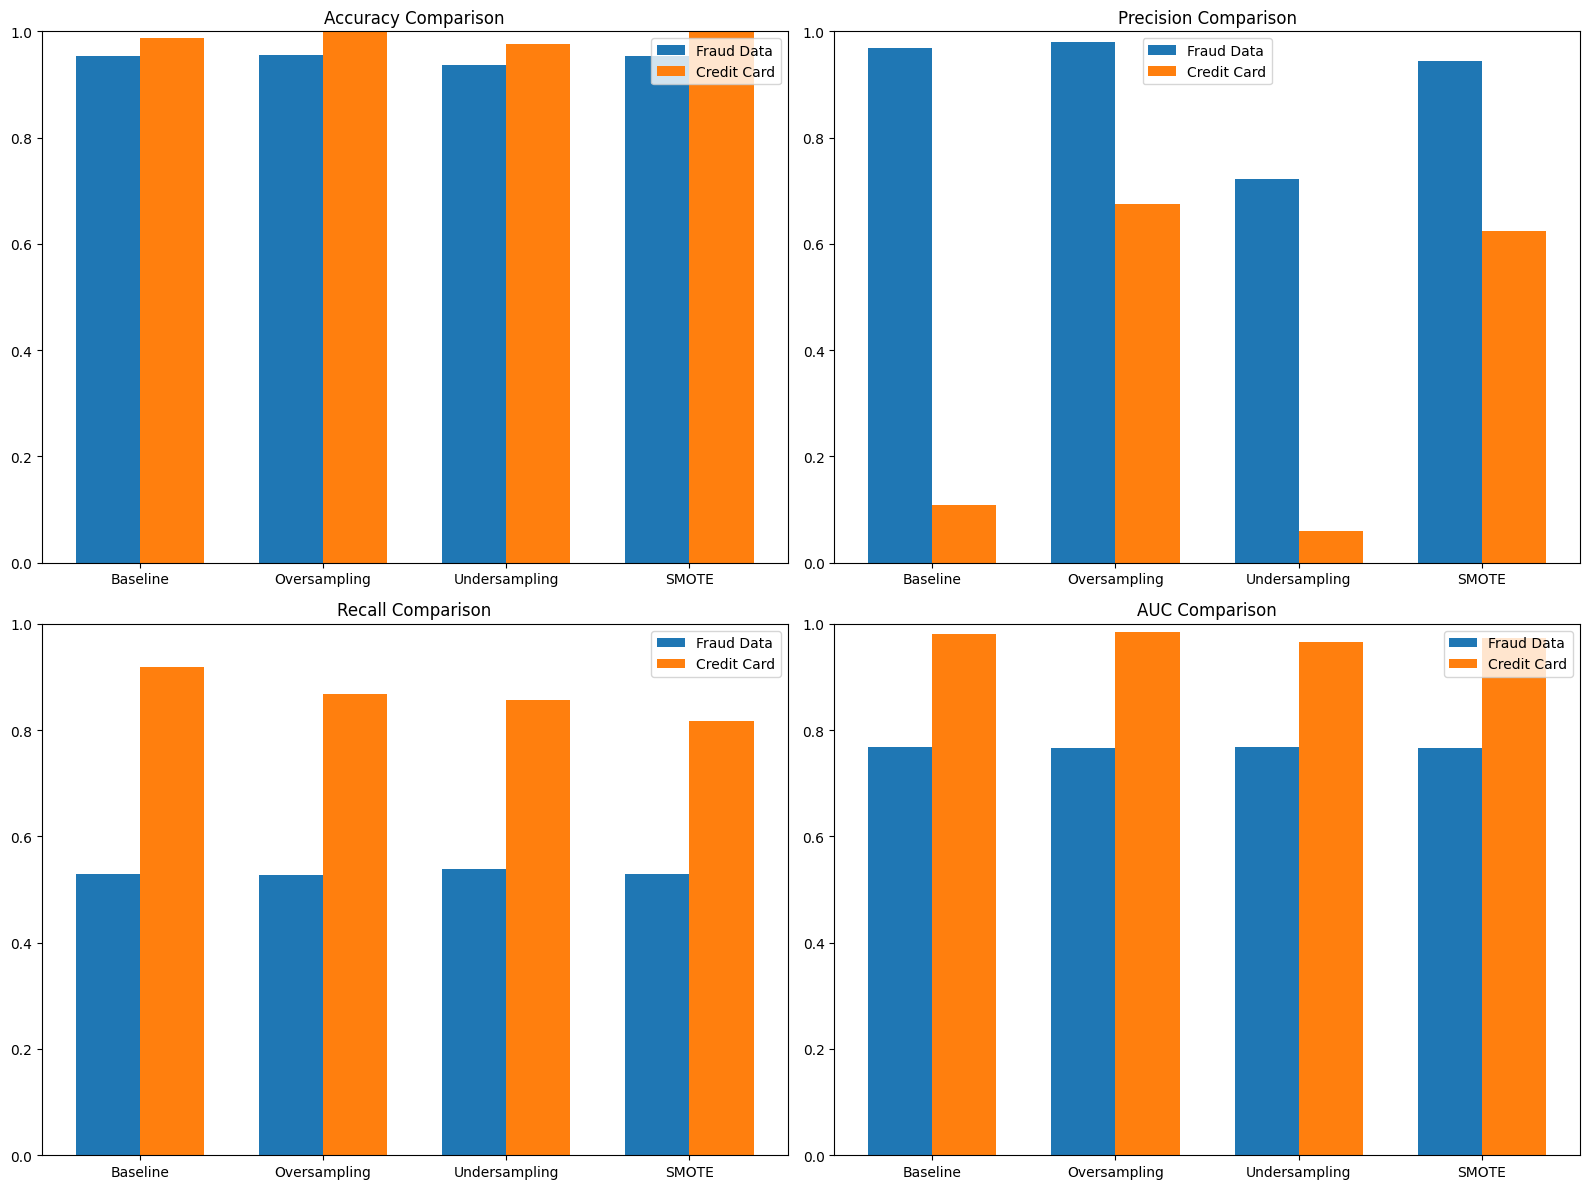

In [36]:
### comparison between data sets 
def compare_datasets_performance(fraud_metrics, credit_metrics):
    metrics = ['Accuracy', 'Precision', 'Recall', 'AUC']
    methods = ['Baseline', 'Oversampling', 'Undersampling', 'SMOTE']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        fraud_values = [m[i] for m in fraud_metrics]
        credit_values = [m[i] for m in credit_metrics]
        
        x = np.arange(len(methods))
        width = 0.35
        
        ax.bar(x - width/2, fraud_values, width, label='Fraud Data')
        ax.bar(x + width/2, credit_values, width, label='Credit Card')
        
        ax.set_title(f'{metric} Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(methods)
        ax.set_ylim(0, 1)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

compare_datasets_performance(
    [fraud_baseline_metrics, fraud_over_metrics, fraud_under_metrics, fraud_smote_metrics],
    [credit_baseline_metrics, credit_over_metrics, credit_under_metrics, credit_smote_metrics]
)

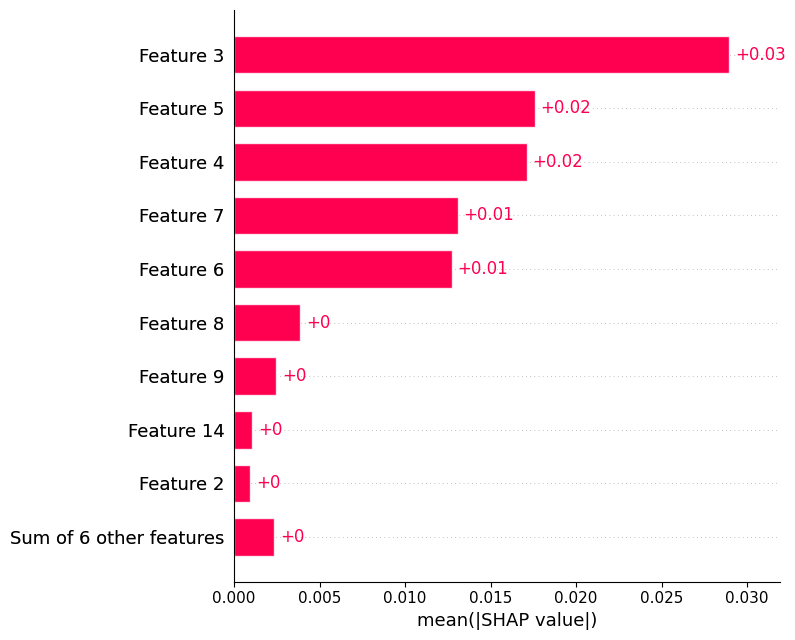

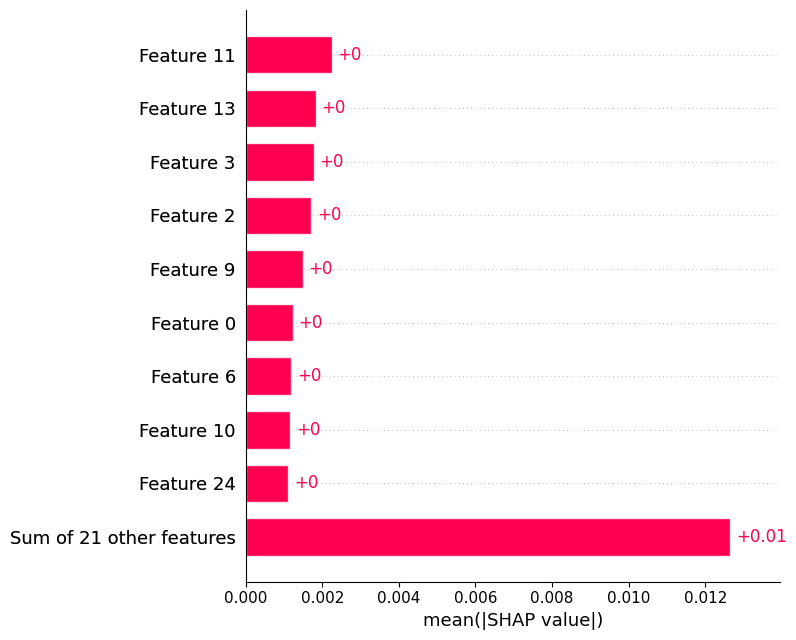

Top 5 Fraud Data features:
            Feature  Importance
3  time_to_purchase    0.028949
5     purchase_hour    0.017585
4       signup_hour    0.017107
7      purchase_day    0.013083
6        signup_day    0.012723

Top 5 Credit Card features:
   Feature  Importance
11     V12    0.002254
13     V14    0.001833
3       V4    0.001778
2       V3    0.001720
9      V10    0.001486


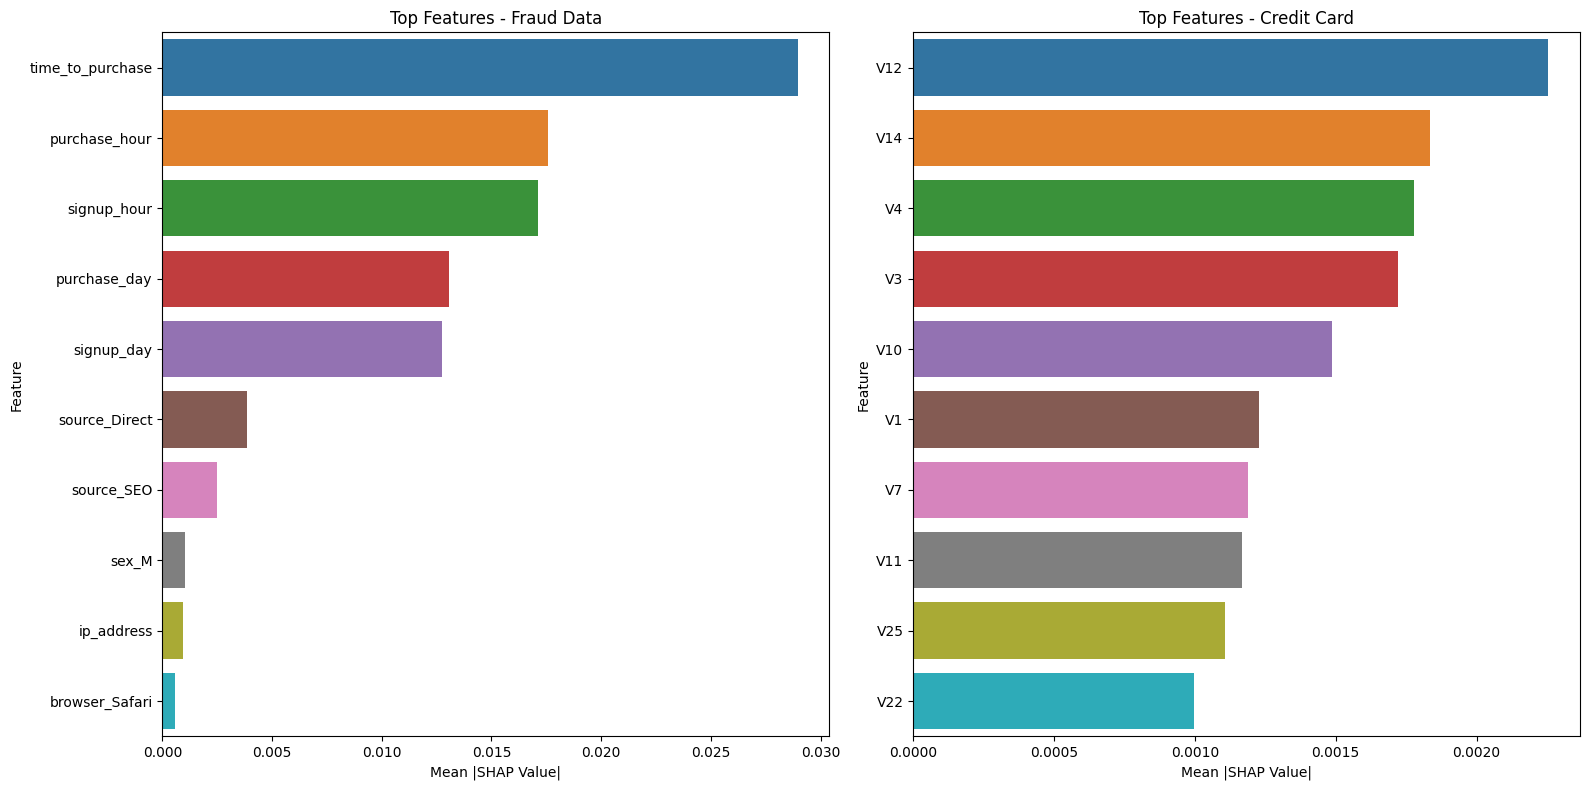

In [55]:
### SHAP analysis
def shap_analysis(model, X_test, feature_names, n_samples=100):

    if len(X_test) > n_samples:
        indices = np.random.choice(len(X_test), n_samples, replace=False)
        X_sample = X_test[indices] if not isinstance(X_test, pd.DataFrame) else X_test.iloc[indices].values
    else:
        X_sample = X_test if not isinstance(X_test, pd.DataFrame) else X_test.values
    
    explainer = shap.Explainer(model, X_sample)
    
    shap_values = explainer(X_sample)
    
    plt.figure(figsize=(12, 8))
    shap.plots.bar(shap_values, show=False)
    plt.tight_layout()
    plt.show()
    
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(shap_values.values).mean(axis=0)
    }).sort_values('Importance', ascending=False)
    
    return importance

fraud_importance = simple_shap_analysis(
    fraud_best_model, 
    X_test_fraud_scaled, 
    fraud_feature_names
)

credit_importance = simple_shap_analysis(
    credit_best_model, 
    X_test_credit, 
    credit_feature_names
)

print("Top 5 Fraud Data features:")
print(fraud_importance.head(5))

print("\nTop 5 Credit Card features:")
print(credit_importance.head(5))

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.barplot(x='Importance', y='Feature', data=fraud_importance.head(10))
plt.title('Top Features - Fraud Data')
plt.xlabel('Mean |SHAP Value|')

plt.subplot(1, 2, 2)
sns.barplot(x='Importance', y='Feature', data=credit_importance.head(10))
plt.title('Top Features - Credit Card')
plt.xlabel('Mean |SHAP Value|')

plt.tight_layout()
plt.show()